In [1]:
import sys, os, math
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import importlib

import torch.nn as nn
from torch.functional import F
import torch.distributions as dist
from torch.utils.data import DataLoader, TensorDataset, random_split

sys.path.append('../')
from utils_modules.models import Expander, vector_to_Cov
from utils_modules.vicreg import vicreg_loss
import utils_modules.data as utils_data
import utils_modules.baryons_toy_Pk as utils_toy_Pk
from scipy import stats

from torch.autograd import Variable
import torch.nn.functional as F
from tqdm import tqdm

/n/home11/aakhmetzhanova/.conda/envs/simclr_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# select device; use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: %s'%(device))

Device: cuda


## Generate parameters

In [3]:
kmin  = 7e-3 #h/Mpc
kmax = 1

kF     = kmin
k_bins = int((kmax-kmin)/kF)
k      = np.arange(3,k_bins+2)*kF 
Nk     = 4.0*np.pi*k**2*kF/kF**3  #number of modes in each k-bin

# model parameters
predict_D     = True
Pk_continuous = True #whether fix A_value for kpivot or not

dset_size = 10000
seed = 17
splits = 1

plot=True
verbose=True

In [4]:
params = utils_toy_Pk.generate_params(dset_size, splits, 
                                                   predict_D = predict_D, 
                                                   Pk_continuous = Pk_continuous,
                                                    seed=seed)
params = params.reshape(dset_size, splits, -1)

Pk = utils_toy_Pk.get_Pk_arr(k, Nk, params, predict_D = predict_D, seed=seed)
log_Pk = torch.tensor(np.log(Pk).reshape(-1, len(k))).float().to(device)

### Load models

In [6]:
# define the encoder model
hidden = 16
last_layer = 32
args_net = [hidden, 
            last_layer, last_layer, last_layer, 
            last_layer, last_layer, last_layer]
###########
inv, var, cov = 15, 15, 1
fmodel = 'trained_models/VICReg_{:d}_{:d}_{:d}.pt'.format(inv, var, cov)
fout   = 'trained_models/VICReg_{:d}_{:d}_{:d}.txt'.format(inv, var, cov)


net = Expander(args_net, k.shape[0], bn = True).to(device)
net.load_state_dict(torch.load(fmodel))
net.eval(); 

###########
inv, var, cov = 15, 15, 1
fmodel = 'trained_models/VICReg_cosmic_var_{:d}_{:d}_{:d}.pt'.format(inv, var, cov)
fout   = 'trained_models/VICReg_cosmic_var_{:d}_{:d}_{:d}.txt'.format(inv, var, cov)

net_cv = Expander(args_net, k.shape[0], bn = True).to(device)
net_cv.load_state_dict(torch.load(fmodel))
net_cv.eval(); 



In [7]:
embedds = net(log_Pk)
embedds_cv = net_cv(log_Pk)

embedds_arr = [embedds, embedds_cv]

labels =  ['D varies + cosmic variance',
           'D constant + cosmic variance']
markers = ['>', 'o']
colors = ['r', 'b']

## Compute Mutual Information

In [8]:
# the code to compute MI with MINE is from
#https://www.cs.cityu.edu.hk/~ccha23/miml/miml.html
class Net(nn.Module):
    def __init__(self, input_size=2, hidden_size=100, sigma=0.02):
        super().__init__()
        # fully-connected (fc) layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # layer 2
        self.fc3 = nn.Linear(hidden_size, 1)  # layer 3
        nn.init.normal_(self.fc1.weight, std=sigma)  #
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight, std=sigma)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight, std=sigma)
        nn.init.constant_(self.fc3.bias, 0)

    def forward(self, x, y):
        """
        Vectorized function that implements the neural network t(x,y).

        Parameters:
        -----------
        x, y: 2D Tensors where the first dimensions index different samples.
        """
        a1 = F.elu(self.fc1(torch.cat([x, y], dim=-1)))
        a2 = F.elu(self.fc2(a1))
        t = self.fc3(a2)
        return t

    
################
class MINETrainer:
    def __init__(
        self, X, Y, net, n_iters_per_epoch, m=1, beta=0.1, **kwargs):
        """
        Neural estimator for Mutual Information based on MINE.

        Estimate I(X;Y) using samples of X and Y by training a network t to maximize
            avg(t(X,Y)) - avg(e^t(X',Y')) / m
        where samples of (X',Y') approximates P_X * P_Y using the resampling trick, and
        m is obtained by smoothing avg(e^t(X',Y')) with the factor beta.

        parameters:
        -----------

        X, Y : Tensors with first dimensions of the same size indicing the samples.
        net  : The neural network t that takes X and Y as input and output a real number for each a real number for each sample.
        n_iters_per_epoch : Number of iterations per epoch.
        m    : initial value for the moving average
        beta : Smoothing/forgetting factor between [0,1]
        writer_params     : Parameters to be passed to SummaryWriter for logging.
        """
        self.X = X
        self.Y = Y
        self.n = min(X.shape[0], Y.shape[0])
        self.beta = beta
        self.m = m
        self.net = net
        self.n_iters_per_epoch = n_iters_per_epoch

        # set optimizer
        self.optimizer = torch.optim.Adam(self.net.parameters(), **kwargs)

        self.n_iter = self.n_epoch = 0

    def step(self, epochs=1):
        """
        Carries out the gradient descend for a number of epochs and returns the MI estimate evaluated over the entire data.

        Loss for each epoch is recorded into the log, but only one MI estimate is computed/logged using the entire dataset.
        Rerun the method to continue to train the neural network and log the results.

        Parameters:
        -----------
        epochs : number of epochs
        """
        for i in range(epochs):
            self.n_epoch += 1

            # random indices for selecting samples for all batches in one epoch
            idx = torch.randperm(self.n)

            # resampling to approximate the sampling of (X',Y')
            idx_X = torch.randperm(self.n)
            idx_Y = torch.randperm(self.n)

            for j in range(self.n_iters_per_epoch):  # loop through multiple batches
                self.n_iter += 1
                self.optimizer.zero_grad()

                # obtain a random batch of samples
                batch_X = self.X[idx[j : self.n : self.n_iters_per_epoch]]
                batch_Y = self.Y[idx[j : self.n : self.n_iters_per_epoch]]
                batch_X_ref = self.X[idx_X[j : self.n : self.n_iters_per_epoch]]
                batch_Y_ref = self.Y[idx_Y[j : self.n : self.n_iters_per_epoch]]

                # define the loss
                # BEGIN SOLUTION
                L = -self.net(batch_X, batch_Y).mean()
                L_ = self.net(batch_X_ref, batch_Y_ref).exp().mean()
                self.m = (1 - self.beta) * L_.detach() + self.beta * self.m
                loss = L + L_ / self.m
                # END SOLUTION
                loss.backward()
                self.optimizer.step()

            
        with torch.no_grad():
            idx_X = torch.randperm(self.n)
            idx_Y = torch.randperm(self.n)
            X_ref = self.X[idx_X]
            Y_ref = self.Y[idx_Y]
            estimate = (
                self.net(self.X, self.Y).mean()
                - self.net(X_ref, Y_ref).logsumexp(0)
                + np.log(self.n)
            ).item()
            return estimate

# (1) D constant

In [9]:
Pk_ary = np.log(Pk).reshape(-1, len(k))
features = embedds_cv.cpu().detach().numpy()
input_length = 1 + features.shape[1]

## (1.1) Example with just one $k$-bin

In [ ]:
mine_net = Net(input_length).to(device)
trainer = MINETrainer(torch.from_numpy(Pk_ary[:, -2:-1]).type(torch.FloatTensor).to(device), 
                      torch.from_numpy(features).type(torch.FloatTensor).to(device), 
                      mine_net, n_iters_per_epoch=5)

MI_estimates = []
for i in range(10000):
    MI_estimates.append(trainer.step())
    if (i+1) % 500 == 0:
        print('MI estimate:', MI_estimates[-1])

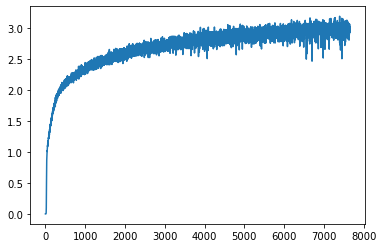

In [14]:
plt.plot(MI_estimates)

## (1.2) Compute MI for each $k$-bin

In [ ]:
num_k_bins = Pk_ary.shape[1]
num_epochs = 10_000
n_iters_per_epoch=5


features = embedds_cv.cpu().detach().type(torch.FloatTensor).to(device)
input_length = 1 + features.shape[1]

all_MI = []
for i in range(num_k_bins):
    Pk_bin = torch.from_numpy(Pk_ary[:, i:(i+1)]).type(torch.FloatTensor).to(device)
    mine_net = Net(input_length).to(device)
    trainer = MINETrainer(Pk_bin, features, 
                          mine_net, n_iters_per_epoch=n_iters_per_epoch)
    
    MI_estimates = []
    for j in range(num_epochs):
        MI_estimates.append(trainer.step())
        
    
    all_MI.append(np.array(MI_estimates))
    np.save('MI_results/MI_D_constant_BPL.npy', np.array(all_MI),)
    print('k-bin: ', i+1)

## (2) D varies

In [ ]:
Pk_ary = np.log(Pk).reshape(-1, len(k))
features = embedds.cpu().detach().numpy()
input_length = 1 + features.shape[1]

In [ ]:
num_k_bins = Pk_ary.shape[1]
num_epochs = 10_000
n_iters_per_epoch=5

input_length = 1 + features.shape[1]
features = embedds.cpu().detach().type(torch.FloatTensor).to(device)

all_MI = []
for i in range(num_k_bins):
    Pk_bin = torch.from_numpy(Pk_ary[:, i:(i+1)]).type(torch.FloatTensor).to(device)
    mine_net = Net(input_length).to(device)
    trainer = MINETrainer(Pk_bin, features, 
                          mine_net, n_iters_per_epoch=n_iters_per_epoch)
    
    MI_estimates = []
    for j in range(num_epochs):
        MI_estimates.append(trainer.step())
        
    
    all_MI.append(np.array(MI_estimates))
    np.save('MI_results/MI_D_varies_BPL.npy', np.array(all_MI),)
    print('k-bin: ', i+1)